# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct = 0
    total = 0
    for (x, y) in loader:
        out = model(x)
        predicted = torch.argmax(out, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()    
    
    return correct/total

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=3)

Average loss: 1.802817, Train accuracy: 0.423216, Val accuracy: 0.557641
Average loss: 1.447369, Train accuracy: 0.586954, Val accuracy: 0.603372
Average loss: 1.378284, Train accuracy: 0.618043, Val accuracy: 0.630128


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.189210, Train accuracy: 0.194229, Val accuracy: 0.216982
Average loss: 2.012985, Train accuracy: 0.277565, Val accuracy: 0.345574
Average loss: 1.803566, Train accuracy: 0.381173, Val accuracy: 0.410484
Average loss: 1.710440, Train accuracy: 0.415708, Val accuracy: 0.420995
Average loss: 1.681564, Train accuracy: 0.431935, Val accuracy: 0.430210


Добавьте слой с Batch Normalization

In [9]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.093633, Train accuracy: 0.293792, Val accuracy: 0.433759
Average loss: 1.775230, Train accuracy: 0.479507, Val accuracy: 0.540919
Average loss: 1.635736, Train accuracy: 0.558305, Val accuracy: 0.596956
Average loss: 1.546692, Train accuracy: 0.599324, Val accuracy: 0.627466
Average loss: 1.482283, Train accuracy: 0.623076, Val accuracy: 0.643233


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
            # use scheduler for lr decreasing
            scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.065998, Train accuracy: 0.316811, Val accuracy: 0.435465
Average loss: 1.769806, Train accuracy: 0.468160, Val accuracy: 0.516688
Average loss: 1.633902, Train accuracy: 0.536071, Val accuracy: 0.574227
Average loss: 1.549310, Train accuracy: 0.572740, Val accuracy: 0.591154
Average loss: 1.493312, Train accuracy: 0.596151, Val accuracy: 0.617569


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [17]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    sampler = SubsetSampler(indices)
    batch_size = 64
    
    loader = torch.utils.data.dataloader.DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    
    predictions, ground_truth = [], []
    
    for (x, y) in loader:
        out = model(x)
        preds = torch.argmax(out, 1)
        predictions.extend(list(preds.numpy()))
        ground_truth.extend(list(y.numpy()))
    
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

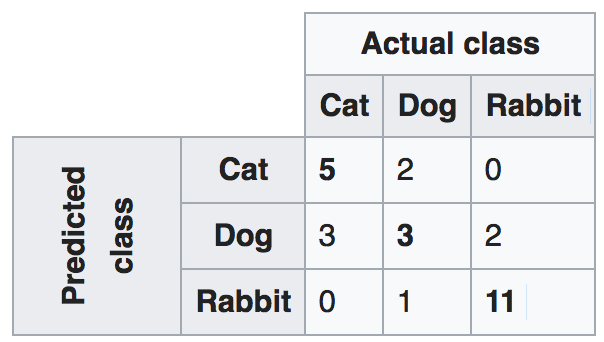

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

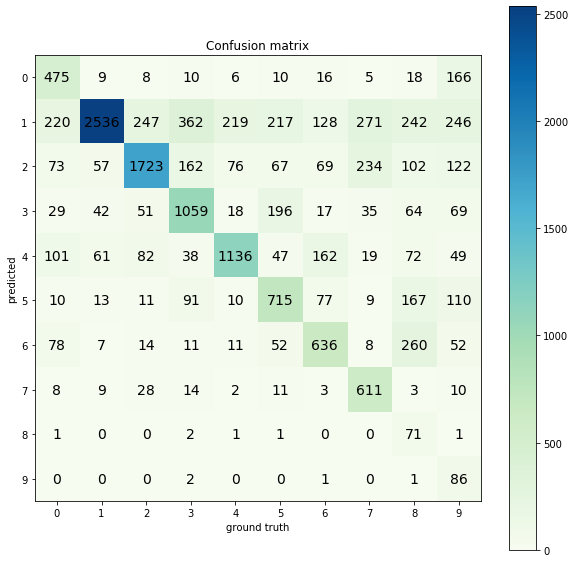

In [26]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    num_class = 10
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(num_class):
        for j in range(num_class):
            confusion_matrix[i, j] = np.sum(predictions[ground_truth == j] == i)
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

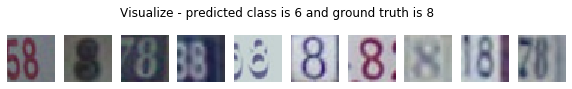

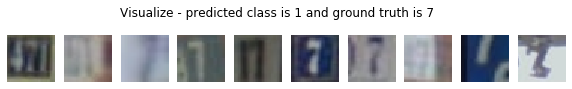

In [27]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    title = f"Visualize - predicted class is {predicted_class} and ground truth is {gt_class}"
    indices = val_indices[(ground_truth == gt_class) & (predictions == predicted_class)]
    
    visualize_images(indices, data, title)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [39]:
# Experiment here!
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, plot_loss=False):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
            if scheduler:
                # use scheduler for lr decreasing
                scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    
    if plot_loss:
        loss_accuracy_plot(loss_history, train_history, val_history)
        
    return loss_history, train_history, val_history

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 7))
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(212)
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")
    plt.legend();

def test_model(model, data=data_test, batch_size=batch_size, test_loader=test_loader):
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    test_accuracy = compute_accuracy(model, test_loader)
    print("Test accuracy: %2.4f" % test_accuracy)

# Exp.1

Average loss: 2.074591, Train accuracy: 0.310685, Val accuracy: 0.422087
Average loss: 1.778315, Train accuracy: 0.465345, Val accuracy: 0.524469
Average loss: 1.632759, Train accuracy: 0.546104, Val accuracy: 0.592792
Average loss: 1.545023, Train accuracy: 0.590178, Val accuracy: 0.620026
Average loss: 1.478719, Train accuracy: 0.618111, Val accuracy: 0.633609


TypeError: test_model() missing 1 required positional argument: 'data_test'

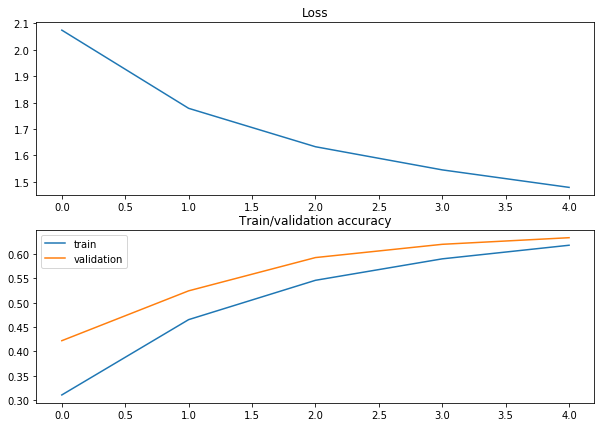

In [37]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 
                                                       plot_loss=True)

In [38]:
# Как всегда, в конце проверяем на test set
test_model(model=nn_model)

Test accuracy: 0.6119


# Exp. 2

Average loss: 1.788136, Train accuracy: 0.442685, Val accuracy: 0.565968
Average loss: 1.498632, Train accuracy: 0.584769, Val accuracy: 0.619889
Average loss: 1.462526, Train accuracy: 0.615210, Val accuracy: 0.640775
Average loss: 1.480331, Train accuracy: 0.620329, Val accuracy: 0.630878
Average loss: 1.509378, Train accuracy: 0.622052, Val accuracy: 0.632312


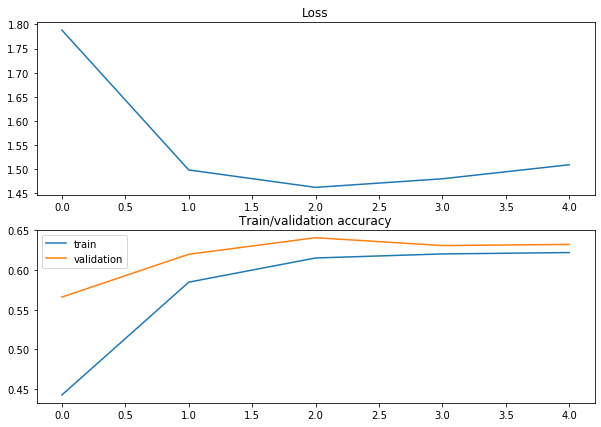

In [43]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.8)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 
                                                       plot_loss=True)

In [44]:
test_model(model=nn_model)

Test accuracy: 0.6122


# Exp. 3

Average loss: 1.809303, Train accuracy: 0.443777, Val accuracy: 0.573749
Average loss: 1.515176, Train accuracy: 0.600365, Val accuracy: 0.624736
Average loss: 1.463232, Train accuracy: 0.624066, Val accuracy: 0.651901
Average loss: 1.473343, Train accuracy: 0.630055, Val accuracy: 0.644734
Average loss: 1.494567, Train accuracy: 0.628929, Val accuracy: 0.628285
Average loss: 1.515487, Train accuracy: 0.622428, Val accuracy: 0.631902
Average loss: 1.527948, Train accuracy: 0.618827, Val accuracy: 0.626578
Average loss: 1.533435, Train accuracy: 0.615227, Val accuracy: 0.621323
Average loss: 1.535003, Train accuracy: 0.615278, Val accuracy: 0.621391
Average loss: 1.536272, Train accuracy: 0.616422, Val accuracy: 0.636202


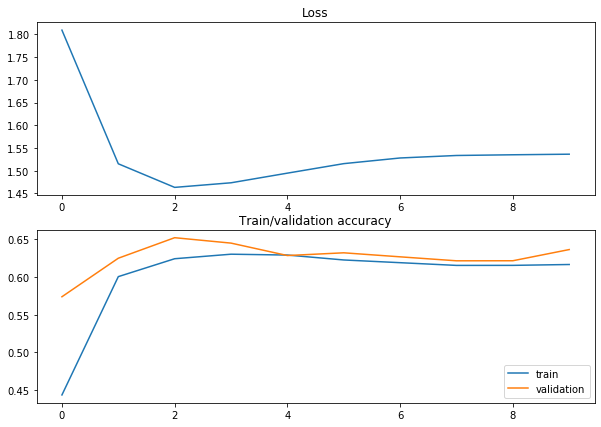

In [46]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.8)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, 
                                                       plot_loss=True)

In [47]:
test_model(model=nn_model)

Test accuracy: 0.6273


# Exp. 4

Average loss: 1.637624, Train accuracy: 0.504078, Val accuracy: 0.620435
Average loss: 1.305293, Train accuracy: 0.649592, Val accuracy: 0.687803
Average loss: 1.277216, Train accuracy: 0.679487, Val accuracy: 0.695993
Average loss: 1.311125, Train accuracy: 0.698751, Val accuracy: 0.714490
Average loss: 1.371591, Train accuracy: 0.699502, Val accuracy: 0.700089


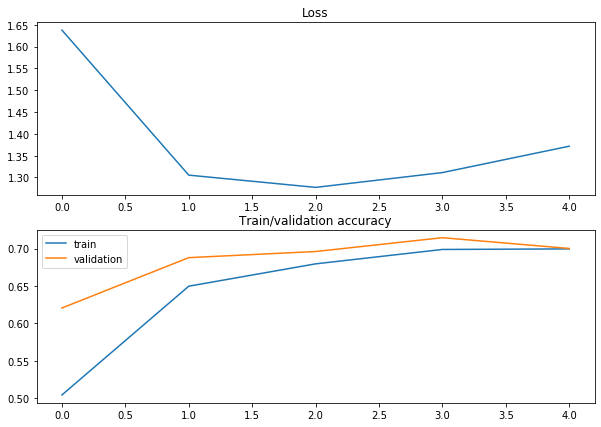

In [50]:
hidden_size = 256
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 10), 
         )

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.8)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 
                                                       plot_loss=True)

In [51]:
test_model(model=nn_model)

Test accuracy: 0.6777


now top accuracy is 